**Libraries and Imports**

In [1]:
!pip install nlpaug matplotlib seaborn imbalanced-learn

import re
import nltk
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import RandomOverSampler

# Download NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 21.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# === Load Dataset === #
df = pd.read_csv('/content/amazon_reviews.csv')

# === Data Preprocessing === #
NEGATION_WORDS = ['not', 'no', 'never', 'neither', 'hardly', 'scarcely']
CUSTOM_STOPWORDS = set(stopwords.words('english')) - {'not', 'no', 'nor'}
CUSTOM_STOPWORDS.update(['um', 'uh', 'eh'])

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Clean and preprocess text data."""
    try:
        # Lowercase, remove HTML, URLs, special characters
        text = text.lower()
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Tokenize and handle negations
        tokens = nltk.word_tokenize(text)
        tokens = handle_negations(tokens)

        # Lemmatize and remove stopwords
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in CUSTOM_STOPWORDS]
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return ''

def handle_negations(tokens):
    """Handle negations in tokens."""
    processed = []
    negate = False
    for token in tokens:
        if token in NEGATION_WORDS:
            negate = True
            processed.append(token)
        elif negate:
            processed[-1] = f"{processed[-1]}_{token}"
            negate = False
        else:
            processed.append(token)
    return processed

def balance_data(X, y):
    """Balance dataset using RandomOverSampler."""
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    return X_resampled, y_resampled

def map_ratings(rating):
    """Map ratings to numerical classes (example: 1, 2, 3)."""
    if rating >= 4:
        return 2  # Positive
    elif rating == 3:
        return 1  # Neutral
    else:
        return 0  # Negative

def sentiment_label(mapped_rating):
    """Map numerical classes to sentiment labels."""
    return {0: 'Negative', 1: 'Neutral', 2: 'Positive'}[mapped_rating]

<ipython-input-3-758cdbb73458>:2: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/amazon_reviews.csv')


In [4]:
# === Model Training and Evaluation === #
def train_and_evaluate(models, X_train, y_train, X_test, y_test):
    """Train and evaluate multiple models."""
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        results[name] = {'accuracy': accuracy, 'f1': f1, 'y_pred': y_pred}

        # Print classification report
        print(f"\n{name} Results:")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"F1 Score: {f1:.2f}")
        print(classification_report(y_test, y_pred))

        # Plot confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Negative', 'Neutral', 'Positive'],
                    yticklabels=['Negative', 'Neutral', 'Positive'])
        plt.title(f"Confusion Matrix: {name}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

    return results


Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.90
F1 Score: 0.90
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      6463
           1       0.87      0.88      0.88      6463
           2       0.90      0.85      0.87      6463

    accuracy                           0.90     19389
   macro avg       0.90      0.90      0.90     19389
weighted avg       0.90      0.90      0.90     19389



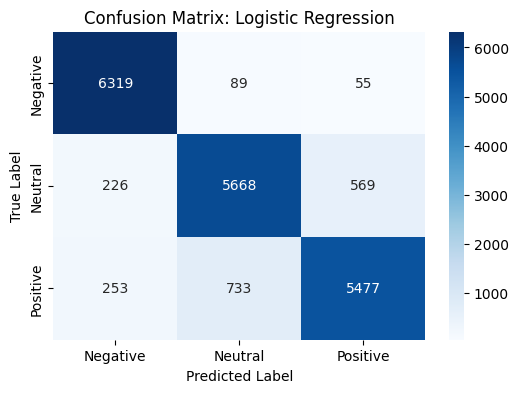


Training Random Forest...

Random Forest Results:
Accuracy: 0.76
F1 Score: 0.76
              precision    recall  f1-score   support

           0       0.84      0.77      0.80      6463
           1       0.71      0.72      0.72      6463
           2       0.74      0.78      0.76      6463

    accuracy                           0.76     19389
   macro avg       0.76      0.76      0.76     19389
weighted avg       0.76      0.76      0.76     19389



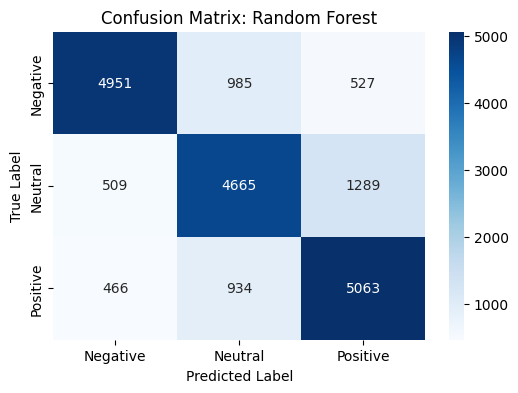


Training SVM...

SVM Results:
Accuracy: 0.93
F1 Score: 0.93
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      6463
           1       0.90      0.93      0.91      6463
           2       0.93      0.86      0.89      6463

    accuracy                           0.93     19389
   macro avg       0.93      0.93      0.93     19389
weighted avg       0.93      0.93      0.93     19389



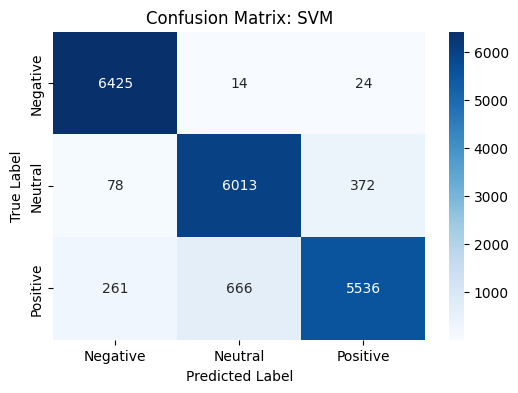

In [5]:
# === Main Script === #
# Clean and preprocess data
df.dropna(subset=['reviews.text', 'reviews.rating'], inplace=True)
df['mapped_rating'] = df['reviews.rating'].apply(map_ratings)
df['cleaned_reviews'] = df['reviews.text'].astype(str).apply(preprocess_text)
df['sentiment'] = df['mapped_rating'].apply(sentiment_label)

# Balance data
X = df['cleaned_reviews']
y = df['mapped_rating']
X_tfidf = TfidfVectorizer(max_features=5000).fit_transform(X)
X_resampled, y_resampled = balance_data(X_tfidf, y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.2, stratify=y_resampled, random_state=42)

# Define models
models = {
    "Logistic Regression": LogisticRegression(C=1.0, penalty='l2', solver='liblinear', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "SVM": SVC(C=1.0, kernel='linear', random_state=42)
}

# Train and evaluate models
results = train_and_evaluate(models, X_train, y_train, X_test, y_test)


In [7]:
# Save the dataset with added sentiment column
df.to_csv('amazon_reviews_sentiment.csv', index=False)
print(f"Saved amazon_reviews_sentiment")

# Save the best model
best_model_name = max(results, key=lambda k: results[k]['accuracy'])
best_model = models[best_model_name]
joblib.dump(best_model, 'sentiment_model.pkl')
print(f"Saved {best_model_name} as sentiment_model.pkl.")

Saved amazon_reviews_sentiment
Saved SVM as sentiment_model.pkl.
